# Basic Shock Model
Now that we have the capacity to simulate a basic supply chain and to generate an event set of flood events in different basins, we are going to combine both of them and apply shocks to a very limited network of firms. This network of firms will now consist of firms that are linked to the Thailand basins. The data is based on the GEM data but some assumptions have been made to ensure that we can test the full potential of the supply chain disruption model.

In [1]:
import pandas as pd

from prisk.asset import Inventory, Capacity, PowerPlant, OilExtractionPlant, OilRefinery, SteelPlant, CementPlant
from prisk.demand import Demand
from prisk.firm import Firm
from prisk.flood import FloodExposure, FloodEvent
from prisk.portfolio import Portfolio
from prisk.utils import return_period_columns, continuous_curves
from prisk.relationships import SupplyChainRelation

import warnings
warnings.filterwarnings("ignore")

### Data
We first start by loading the data. The data is provided in a template excel file that consists of multiple sheets each having their own specific set of data.

In [2]:
# All files for the analysis are stored on the S3 buckets instead of the random samples (these are too large and take a long time to load)
url = "../cleaning/dummy_supply_chain.xlsx"
assets = pd.read_excel(url, sheet_name="assets")
firms = pd.read_excel(url, sheet_name="firms")
ownership = pd.read_excel(url, sheet_name="ownership")
supply_chain = pd.read_excel(url, sheet_name="supply chain")
critical_infrastructure = pd.read_excel(url, sheet_name="critical infrastructure")
flood_exposure = pd.read_excel(url, sheet_name="flood exposure")

In [3]:
time_horizon = 5

Make production levels as realistic as possible. We do this using a two-step procedure/ In the first step, we apply the leontief model to obtain values for the final demands. However, there can be issues with these demands as they could be negative. Therefore, we add a second step, where we make the negative final demands equal to 0, and then we recompute the production values in the leontief model.

In [4]:
firm_productions = pd.merge(firms, ownership, on="firm_id", how="left")
firm_productions = pd.merge(firm_productions, assets, on="asset_id", how="left")
firm_productions["production"] = firm_productions["share"] * firm_productions["production"]
firm_productions = firm_productions.groupby("firm_id").sum()

# Leontief model
import numpy as np

# production values (output)
productions = firm_productions["production"].values  

# matrix of coefficients
A = np.zeros((len(productions), len(productions)))
for _, row in supply_chain.iterrows():
    A[int(row["supplier"]), int(row["client"])] = row["recipe"]

# calculate final demand
final_demand = (np.eye(len(productions)) - A) @ productions
firms["final_demand"] = pd.Series(final_demand, index=firms.index).apply(lambda x: max(0, x))
# Leontief model
import numpy as np

final_demands = firms["final_demand"].values
A = np.zeros((len(final_demands), len(final_demands)))
for _, row in supply_chain.iterrows():
    A[int(row["supplier"]), int(row["client"])] = row["recipe"]
# calculate output
output = np.linalg.solve(np.eye(len(final_demands)) - A, final_demands)

firm_productions["output"] = output
firm_productions["scaler"] = firm_productions["output"] / firm_productions["production"]

# Now hat we have the output of each firm, we can calculate the production of each asset
for firm, row in firm_productions.iterrows():
    asset_ids = ownership[ownership["firm_id"] == firm]["asset_id"].values
    for asset_id in asset_ids:
        assets.loc[assets["asset_id"] == asset_id, "production"] *= row["scaler"]

### Network Construction
A key step in the analysis is the construction of a supply chain network. This network consists of assets, firms, and the relationships between these.

In [5]:
asset_floods = pd.merge(assets, flood_exposure, on="asset_id", how="left")
asset_objects = []
for _, row in asset_floods.iterrows():
    flood_exposures = [
        FloodExposure(
            return_period=return_period,
            depth=row.loc[return_period],
        )
        for return_period in return_period_columns
    ]
    if row["product"] == "power":
        asset = PowerPlant(
            name=row["name"],
            latitude=row["latitude"],
            longitude=row["longitude"],
            capacity=Capacity(current=row["production"], constrained=row["production"]*1.2, maximum=row["production"]*1.2),
            inventory=Inventory(current=row["production"]*3, desired=row["production"]*3, maximum=row["production"]*5),
            flood_damage_curve=continuous_curves[["production", "damage"]],
            flood_exposure=flood_exposures,
            replacement_value=row["replacement_value"],
            flood_protection=row["flood_protection"]    
        )
    elif row["product"] == "oil":
        asset = OilExtractionPlant(
            name=row["name"],
            latitude=row["latitude"],
            longitude=row["longitude"],
            capacity=Capacity(current=row["production"], constrained=row["production"]*1.2, maximum=row["production"]*1.2),
            inventory=Inventory(current=row["production"]*3, desired=row["production"]*3, maximum=row["production"]*5),
            flood_damage_curve=continuous_curves[["production", "damage"]],
            flood_exposure=flood_exposures,
            replacement_value=row["replacement_value"],
            flood_protection=row["flood_protection"] 
        )
    elif row["product"] == "refined oil":
        asset = OilRefinery(
            name=row["name"],
            latitude=row["latitude"],
            longitude=row["longitude"],
            capacity=Capacity(current=row["production"], constrained=row["production"]*1.2, maximum=row["production"]*1.2),
            inventory=Inventory(current=row["production"]*3, desired=row["production"]*3, maximum=row["production"]*5),
            flood_damage_curve=continuous_curves[["production", "damage"]],
            flood_exposure=flood_exposures,
            replacement_value=row["replacement_value"],
            flood_protection=row["flood_protection"] 
        )
    elif row["product"] == "steel":
        asset = SteelPlant(
            name=row["name"],
            latitude=row["latitude"],
            longitude=row["longitude"],
            capacity=Capacity(current=row["production"], constrained=row["production"]*1.2, maximum=row["production"]*1.2),
            inventory=Inventory(current=row["production"]*3, desired=row["production"]*3, maximum=row["production"]*5),
            flood_damage_curve=continuous_curves[["production", "damage"]],
            flood_exposure=flood_exposures,
            replacement_value=row["replacement_value"],
            flood_protection=row["flood_protection"] 
        )
    elif row["product"] == "cement":
        asset = CementPlant(
            name=row["name"],
            latitude=row["latitude"],
            longitude=row["longitude"],
            capacity=Capacity(current=row["production"], constrained=row["production"]*1.2, maximum=row["production"]*1.2),
            inventory=Inventory(current=row["production"]*3, desired=row["production"]*3, maximum=row["production"]*5),
            flood_damage_curve=continuous_curves[["production", "damage"]],
            flood_exposure=flood_exposures,
            replacement_value=row["replacement_value"],
            flood_protection=row["flood_protection"] 
        )
    else:
        raise ValueError(f"Unknown product: {row['product']}")
    asset_objects.append(asset)

Next, we create the firms and link the assets to the firms:

In [6]:
firm_objects = []
for _, row in firms.iterrows():
    firm = Firm(
        name=row["name"],
        final_demand=Demand(initial=row["final_demand"],
                            current=row["final_demand"],
                            constrained=row["final_demand"])
    )
    firm_objects.append(firm)

Next, we create the ownership relations:

In [7]:
for _, o in ownership.iterrows():
    firm = firm_objects[o["firm_id"]]
    asset = asset_objects[o["asset_id"]]
    firm.add_asset(asset, ownership=o["share"])

And finally, we create the supply chain relations:

In [8]:
for _, sc in supply_chain.iterrows():
    client = firm_objects[int(sc["client"])]
    supplier = firm_objects[int(sc["supplier"])]
    relation = SupplyChainRelation(
        client=client,
        supplier=supplier,
        recipe_input=sc["recipe"],
        product=sc["product"]
    )

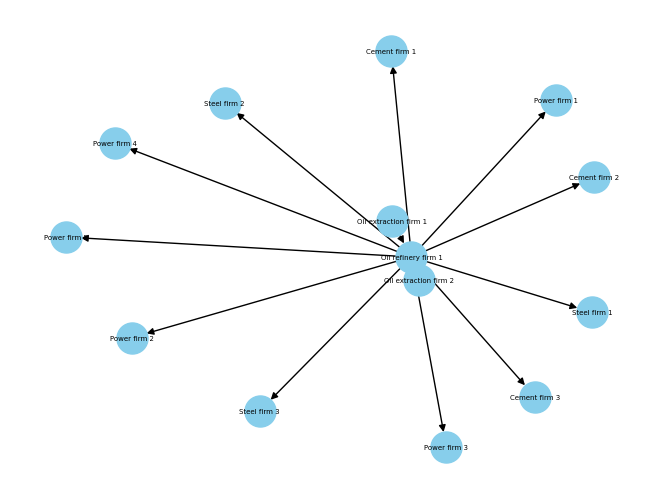

In [9]:
SupplyChainRelation.visualize()

### Constructing financial portfolios
The next step in the analysis is the construction of a collection of financial portfolios that are held by banks.

In [10]:
portfolio = Portfolio("Thailand power assets")
nav = 1
for firm in firm_objects:
    portfolio.add_position(firm, nav/(len(firms)*firm.npv)) 

start_value = portfolio.underlying_value  

### Run the simulation

In [11]:
from prisk.kernel import Kernel

simulation = Kernel(
    assets=asset_objects,
    insurers=[]
)

Next, we generate the extreme events that have occured.

In [12]:
oil_extraction_plant = asset_objects[9]
event = FloodEvent(time=100, depth=7, asset=oil_extraction_plant)
simulation.messages.put(event)

In [13]:
simulation.run(1200)

Name: Power firm 1
NPV: 227994162.65643612
Base NPV: 231369558.65643612
PRISK: 0.9854112355160249
Input bottleneck: {'power': np.float64(560.0)}
Current inventory: {'power': np.float64(328.0)}
Desired inventory: {'power': 330}
Maximum production: {'power': np.float64(132.0)}
Final demand: 103.0
Production schedule: {'power': np.float64(99.0)}
Forecasted demand: {'power': np.float64(106.0)}
Orders:  []
Recipe:  {'refined oil': 0.8}
Product inventories: [('refined oil', np.float64(305.0))]
Input bottlenecks: [(Power Plant 1, np.float64(305.0)), (Power Plant 2, np.float64(255.0))]


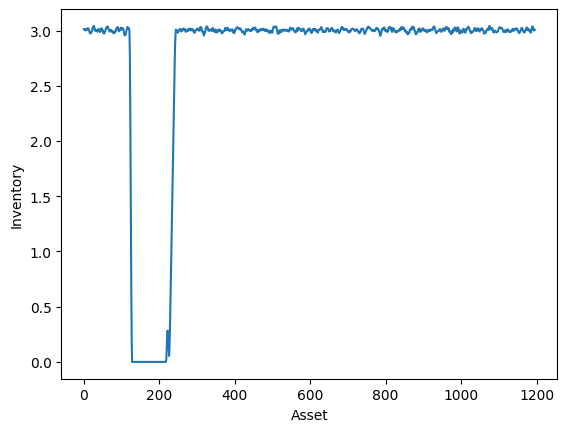

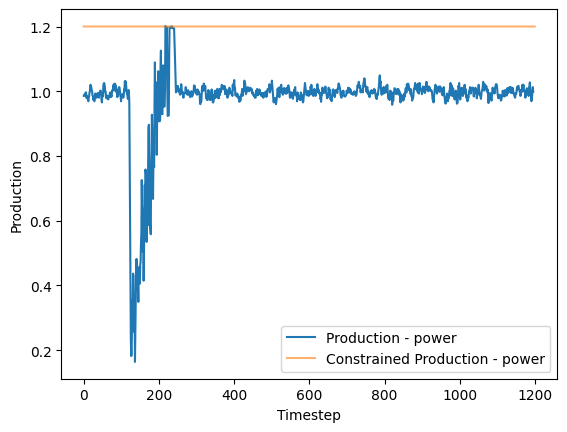

-----
Name: Power firm 2
NPV: 112723737.32821806
Base NPV: 115684779.32821806
PRISK: 0.9744042213920034
Input bottleneck: {'power': np.float64(275.0)}
Current inventory: {'power': np.float64(166.0)}
Desired inventory: {'power': 165}
Maximum production: {'power': np.float64(66.0)}
Final demand: 54.0
Production schedule: {'power': np.float64(53.0)}
Forecasted demand: {'power': np.float64(54.0)}
Orders:  []
Recipe:  {'refined oil': 0.4}
Product inventories: [('refined oil', np.float64(275.0))]
Input bottlenecks: [(Power Plant 3, np.float64(275.0))]


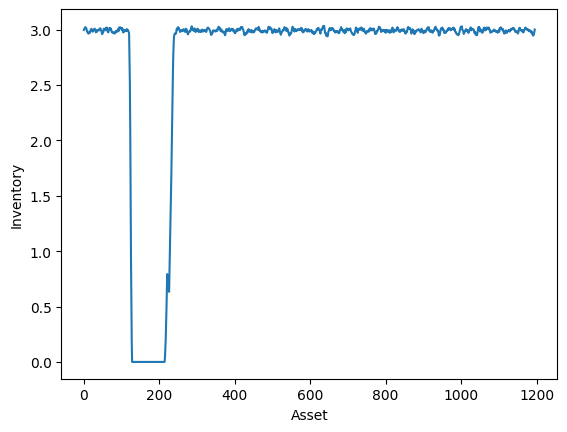

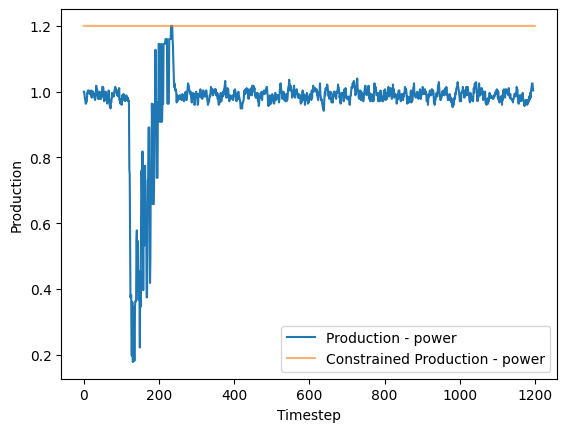

-----
Name: Power firm 3
NPV: 103663845.20747095
Base NPV: 105167981.20747095
PRISK: 0.9856977762363556
Input bottleneck: {'power': np.float64(200.0)}
Current inventory: {'power': np.float64(150.0)}
Desired inventory: {'power': 150}
Maximum production: {'power': np.float64(60.0)}
Final demand: 49.0
Production schedule: {'power': np.float64(50.0)}
Forecasted demand: {'power': np.float64(49.0)}
Orders:  []
Recipe:  {'refined oil': 0.3}
Product inventories: [('refined oil', np.float64(200.0))]
Input bottlenecks: [(Power Plant 4, np.float64(200.0))]


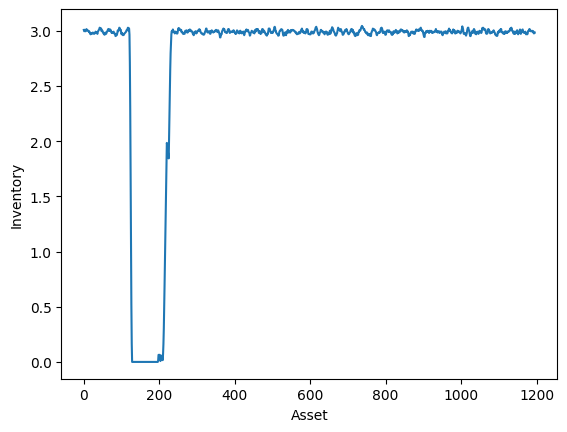

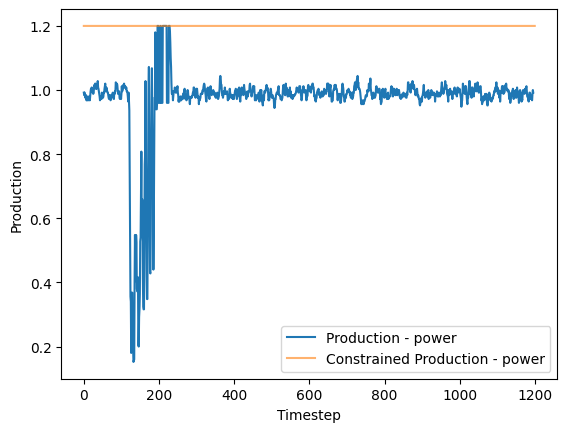

-----
Name: Power firm 4
NPV: 102934733.20747097
Base NPV: 105167981.20747097
PRISK: 0.9787649437180472
Input bottleneck: {'power': np.float64(215.0)}
Current inventory: {'power': np.float64(150.0)}
Desired inventory: {'power': 150}
Maximum production: {'power': np.float64(60.0)}
Final demand: 52.0
Production schedule: {'power': np.float64(52.0)}
Forecasted demand: {'power': np.float64(49.0)}
Orders:  []
Recipe:  {'refined oil': 0.2}
Product inventories: [('refined oil', np.float64(100.0))]
Input bottlenecks: [(Power Plant 5, np.float64(100.0)), (Power Plant 6, np.float64(115.0))]


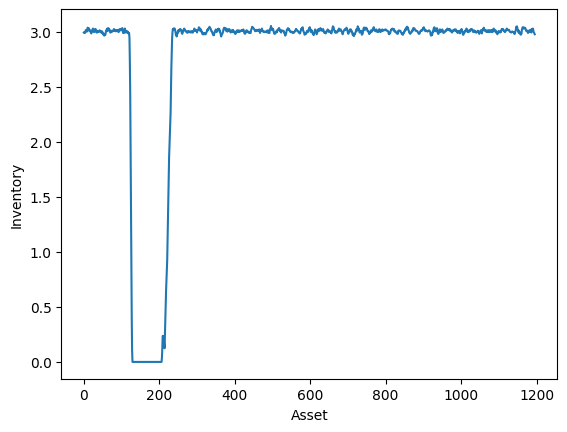

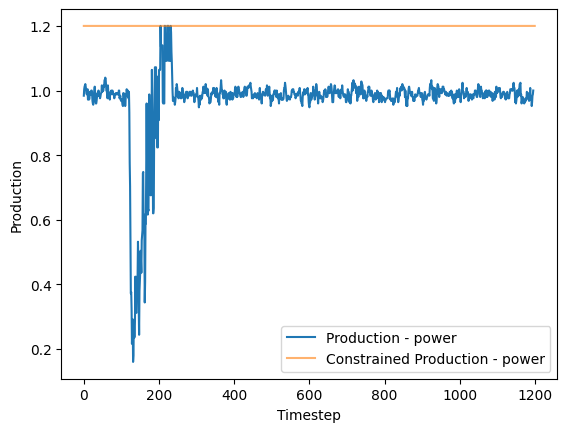

-----
Name: Power firm 5
NPV: 102506877.20747095
Base NPV: 105167981.20747095
PRISK: 0.9746966332390626
Input bottleneck: {'power': np.float64(250.0)}
Current inventory: {'power': np.float64(147.0)}
Desired inventory: {'power': 150}
Maximum production: {'power': np.float64(60.0)}
Final demand: 50.0
Production schedule: {'power': np.float64(49.0)}
Forecasted demand: {'power': np.float64(48.0)}
Orders:  []
Recipe:  {'refined oil': 0.5}
Product inventories: [('refined oil', np.float64(250.0))]
Input bottlenecks: [(Power Plant 7, np.float64(250.0))]


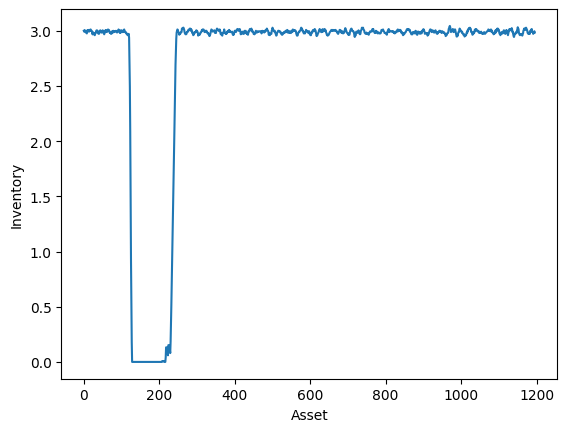

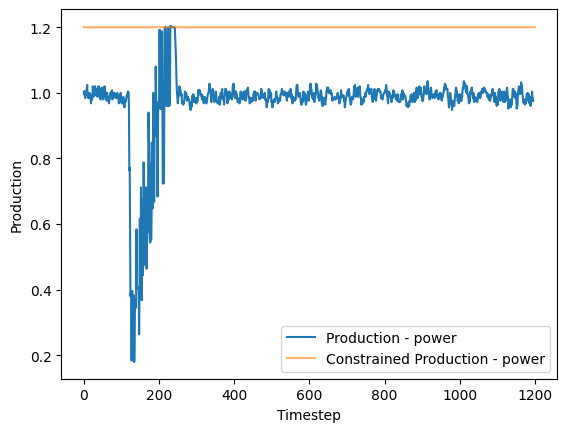

-----
Name: Oil refinery firm 1
NPV: 804806012.4182737
Base NPV: 820310253.4182737
PRISK: 0.9810995401613072
Input bottleneck: {'refined oil': np.float64(1348.8888888888891)}
Current inventory: {'refined oil': np.float64(1184.0)}
Desired inventory: {'refined oil': 1170}
Maximum production: {'refined oil': np.float64(468.0)}
Final demand: 0.0
Production schedule: {'refined oil': np.float64(404.0)}
Forecasted demand: {'refined oil': np.float64(398.0)}
Orders:  []
Recipe:  {'crude oil': 0.8999999999999999}
Product inventories: [('crude oil', np.float64(715.5555555555557))]
Input bottlenecks: [(Oil refinery 1, np.float64(715.5555555555557)), (Oil refinery 2, np.float64(633.3333333333334))]


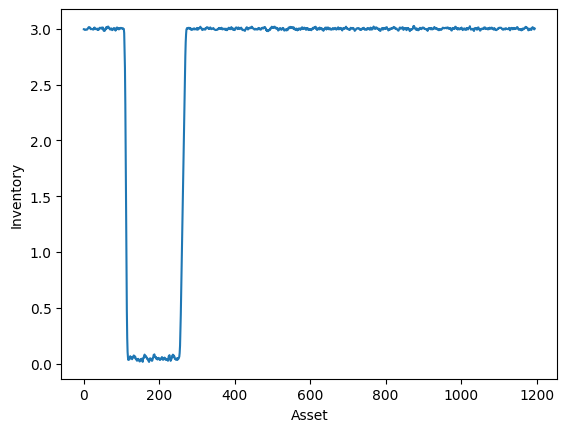

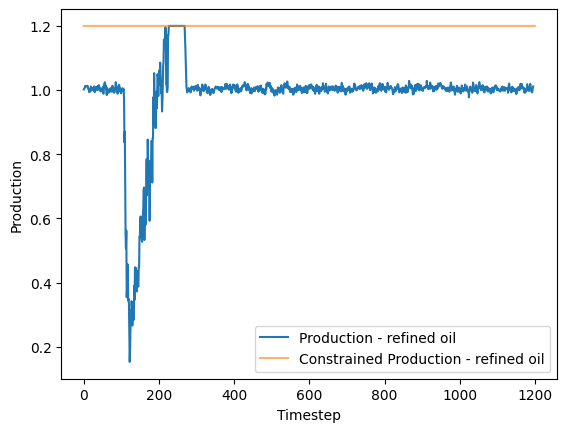

-----
Name: Oil extraction firm 1
NPV: 511123777.8230792
Base NPV: 437498801.8230792
PRISK: 1.1682861203121038
Input bottleneck: {'crude oil': 2e+100}
Current inventory: {'crude oil': np.float64(60.47321428571428)}
Desired inventory: {'crude oil': 624}
Maximum production: {'crude oil': np.float64(249.6)}
Final demand: 129.0
Production schedule: {'crude oil': np.float64(249.6)}
Forecasted demand: {'crude oil': np.float64(282.0)}
Orders:  [Order(time=1197, quantity=np.float64(76.0), client=Oil refinery firm 1, product='crude oil', asset=Oil refinery 1, fulfilled=False, received=False, time_till_delivery=2), Order(time=1197, quantity=np.float64(76.0), client=Oil refinery firm 1, product='crude oil', asset=Oil refinery 2, fulfilled=False, received=False, time_till_delivery=1), Order(time=1198, quantity=np.float64(75.0), client=Oil refinery firm 1, product='crude oil', asset=Oil refinery 1, fulfilled=False, received=False, time_till_delivery=1), Order(time=1198, quantity=np.float64(75.0), c

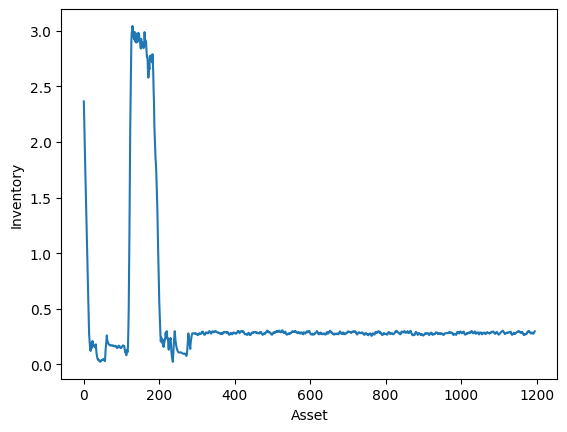

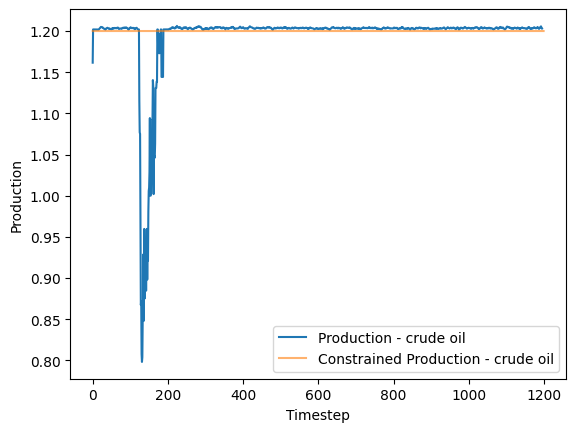

-----
Name: Oil extraction firm 2
NPV: 424913450.5135386
Base NPV: 584733975.5135386
PRISK: 0.7266782302847398
Input bottleneck: {'crude oil': 1e+100}
Current inventory: {'crude oil': np.float64(827.0)}
Desired inventory: {'crude oil': 834}
Maximum production: {'crude oil': np.float64(333.59999999999997)}
Final demand: 5.0
Production schedule: {'crude oil': np.float64(204.0)}
Forecasted demand: {'crude oil': np.float64(205.0)}
Orders:  []
Recipe:  {}
Product inventories: []
Input bottlenecks: [(Oil Extraction 3, 1e+100)]


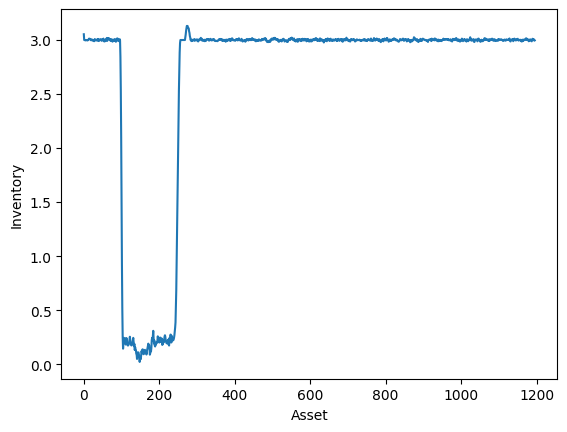

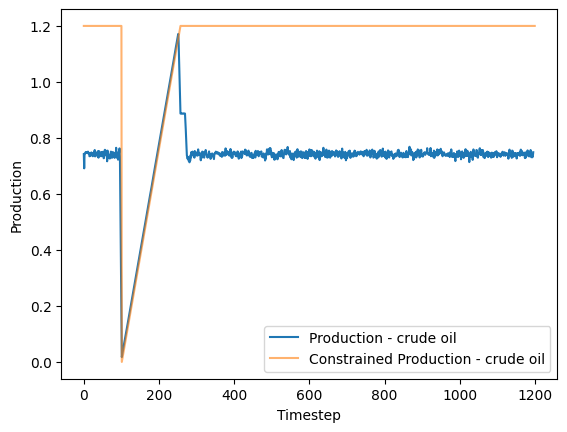

-----
Name: Steel firm 1
NPV: 102718180.20747095
Base NPV: 105167981.20747095
PRISK: 0.976705828410197
Input bottleneck: {'steel': np.float64(248.88888888888889)}
Current inventory: {'steel': np.float64(150.0)}
Desired inventory: {'steel': 150}
Maximum production: {'steel': np.float64(60.0)}
Final demand: 48.0
Production schedule: {'steel': np.float64(51.0)}
Forecasted demand: {'steel': np.float64(49.0)}
Orders:  []
Recipe:  {'refined oil': 0.9}
Product inventories: [('refined oil', np.float64(248.88888888888889))]
Input bottlenecks: [(Steel plant 1, np.float64(248.88888888888889))]


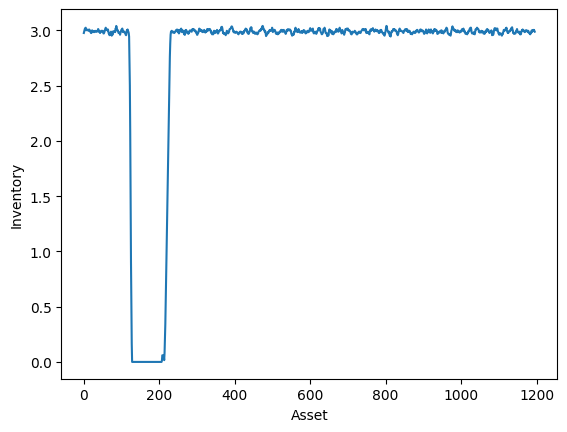

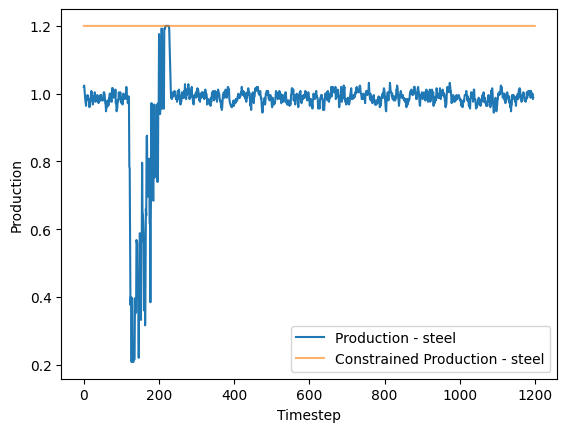

-----
Name: Steel firm 2
NPV: 102678972.20747095
Base NPV: 105167981.20747095
PRISK: 0.9763330153206061
Input bottleneck: {'steel': np.float64(190.0)}
Current inventory: {'steel': np.float64(152.0)}
Desired inventory: {'steel': 150}
Maximum production: {'steel': np.float64(60.0)}
Final demand: 50.0
Production schedule: {'steel': np.float64(50.0)}
Forecasted demand: {'steel': np.float64(50.0)}
Orders:  []
Recipe:  {'refined oil': 0.1}
Product inventories: [('refined oil', np.float64(190.0))]
Input bottlenecks: [(Steel plant 2, np.float64(190.0))]


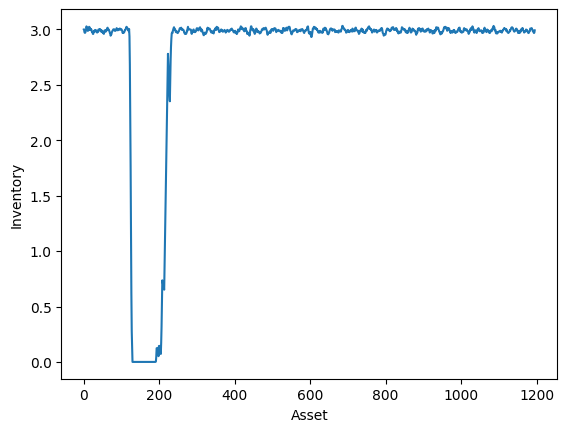

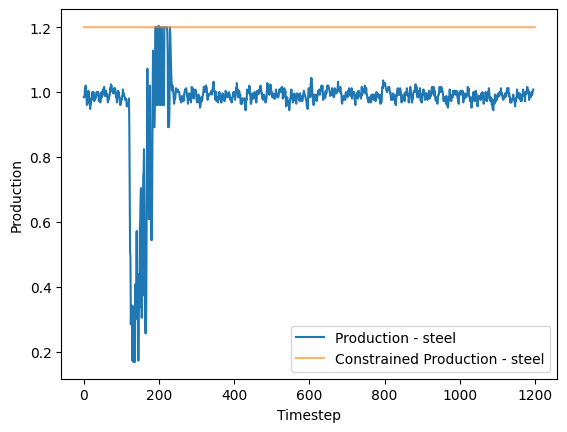

-----
Name: Steel firm 3
NPV: 102240069.20747095
Base NPV: 105167981.20747095
PRISK: 0.9721596633653741
Input bottleneck: {'steel': np.float64(190.0)}
Current inventory: {'steel': np.float64(150.0)}
Desired inventory: {'steel': 150}
Maximum production: {'steel': np.float64(60.0)}
Final demand: 51.0
Production schedule: {'steel': np.float64(53.0)}
Forecasted demand: {'steel': np.float64(51.0)}
Orders:  []
Recipe:  {'refined oil': 0.1}
Product inventories: [('refined oil', np.float64(190.0))]
Input bottlenecks: [(Steel plant 3, np.float64(190.0))]


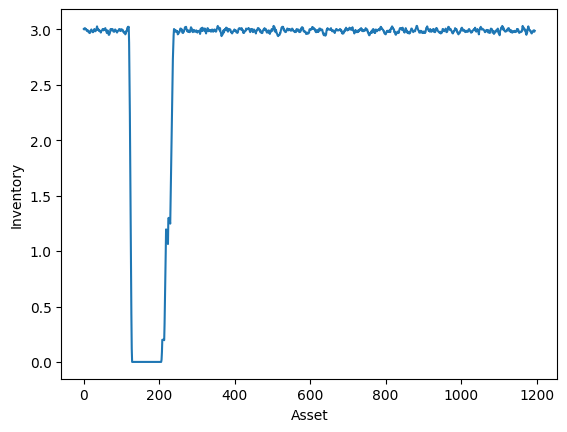

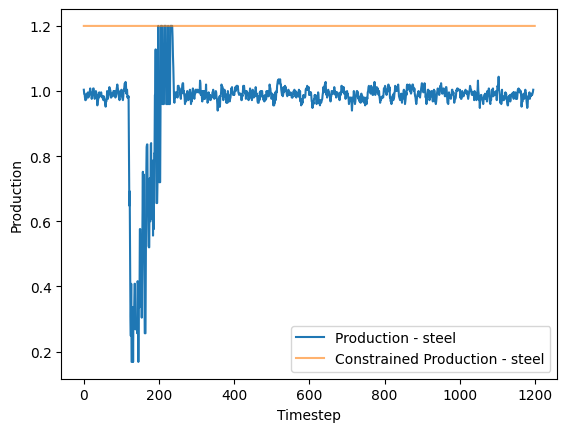

-----
Name: Cement firm 1
NPV: 102631718.20747095
Base NPV: 105167981.20747095
PRISK: 0.9758836960557742
Input bottleneck: {'cement': np.float64(250.0)}
Current inventory: {'cement': np.float64(149.0)}
Desired inventory: {'cement': 150}
Maximum production: {'cement': np.float64(60.0)}
Final demand: 52.0
Production schedule: {'cement': np.float64(50.0)}
Forecasted demand: {'cement': np.float64(49.0)}
Orders:  []
Recipe:  {'refined oil': 0.1}
Product inventories: [('refined oil', np.float64(250.0))]
Input bottlenecks: [(Cement Plant 1, np.float64(250.0))]


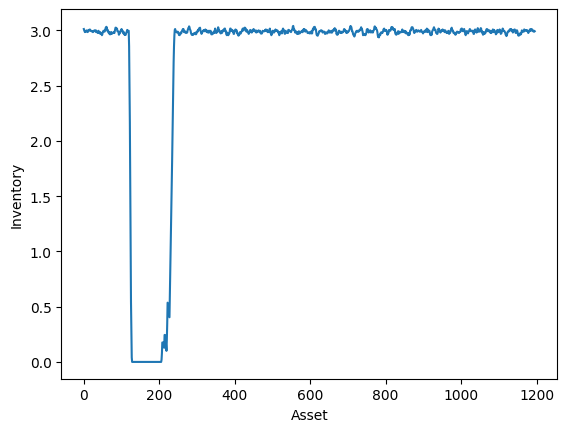

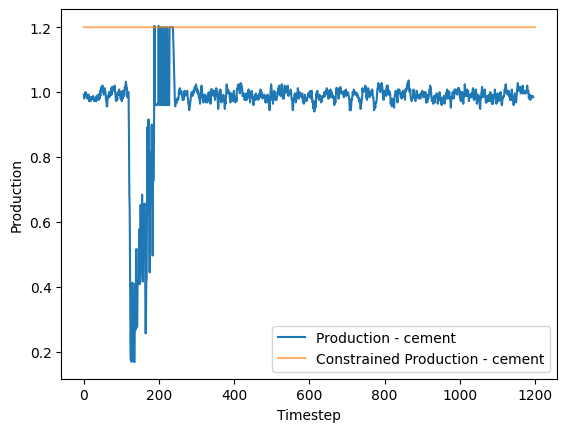

-----
Name: Cement firm 2
NPV: 206671230.4149419
Base NPV: 210335962.4149419
PRISK: 0.9825767692888847
Input bottleneck: {'cement': np.float64(450.0)}
Current inventory: {'cement': np.float64(297.0)}
Desired inventory: {'cement': 300}
Maximum production: {'cement': np.float64(120.0)}
Final demand: 100.0
Production schedule: {'cement': np.float64(100.0)}
Forecasted demand: {'cement': np.float64(100.0)}
Orders:  []
Recipe:  {'refined oil': 0.8}
Product inventories: [('refined oil', np.float64(200.0))]
Input bottlenecks: [(Cement Plant 2, np.float64(200.0)), (Cement Plant 3, np.float64(250.0))]


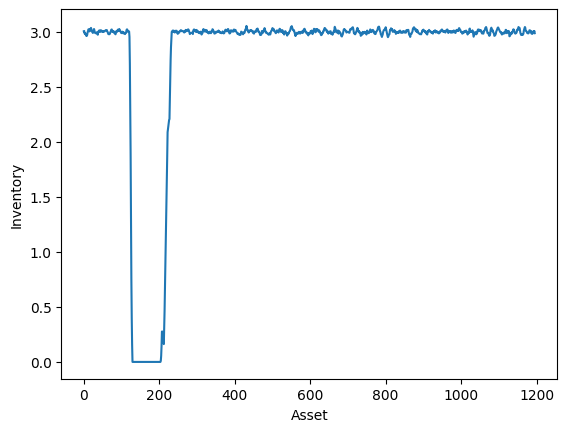

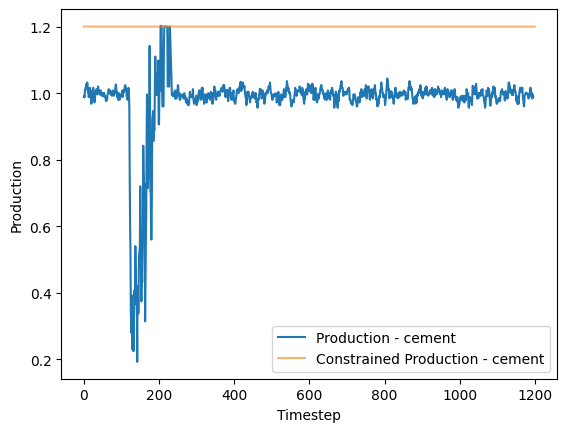

-----
Name: Cement firm 3
NPV: 205756756.4149419
Base NPV: 210335962.4149419
PRISK: 0.9782290867076437
Input bottleneck: {'cement': np.float64(502.22222222222223)}
Current inventory: {'cement': np.float64(298.0)}
Desired inventory: {'cement': 300}
Maximum production: {'cement': np.float64(120.0)}
Final demand: 100.0
Production schedule: {'cement': np.float64(97.0)}
Forecasted demand: {'cement': np.float64(98.0)}
Orders:  []
Recipe:  {'refined oil': 0.9}
Product inventories: [('refined oil', np.float64(251.11111111111111))]
Input bottlenecks: [(Cement Plant 4, np.float64(251.11111111111111)), (Cement Plant 5, np.float64(251.11111111111111))]


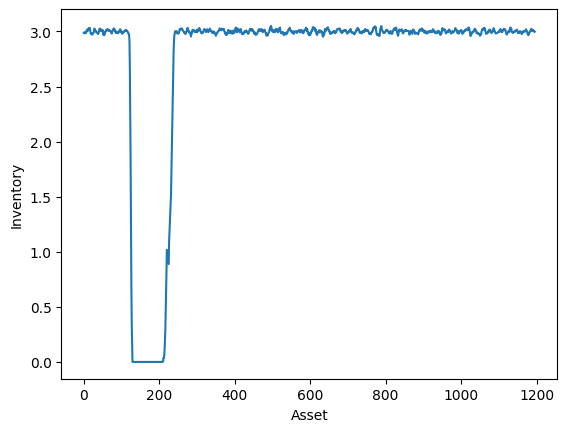

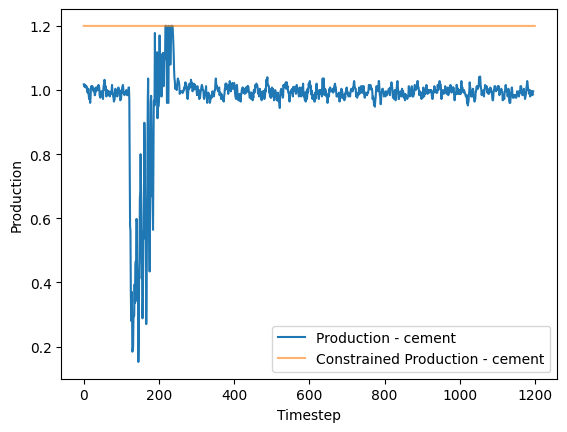

-----


In [14]:
for firm in firm_objects:
    if isinstance(firm, Firm):
        print("Name:", firm.name)
        print("NPV:", firm.npv)
        print("Base NPV:", firm.base_value)
        print("PRISK:", firm.npv / firm.base_value)
        print("Input bottleneck:", firm.input_bottleneck)
        print("Current inventory:", firm.inventory)
        print("Desired inventory:", firm.desired_inventory)
        print("Maximum production:", firm.maximum_production)
        print("Final demand:", firm.final_demand.current)
        print("Production schedule:", firm.production_schedule)
        print("Forecasted demand:", firm.forecasted_demand)
        print("Orders: ", [order for order in firm.orders
                                if not order.fulfilled])
        print("Recipe: ", firm.assets[0].recipe)
        asset = firm.assets[0]
        print("Product inventories:", [
            (product, asset.input_inventory[product] / recipe)
            for product, recipe in asset.recipe.items()
        ])
        print("Input bottlenecks:", [
            (asset, asset.bottleneck_production)
            for asset in firm.assets
        ])
        firm.visualize_inventory_history(window_size=5, proportion=True)
        firm.visualize_production_history(window_size=5, proportion=True)
        print("-----")

In [15]:
print(f"Portfolio impact: {-1 + (portfolio.underlying_value/start_value):.2%}")

Portfolio impact: -2.59%


In [16]:
for asset in asset_objects:
    asset.plot_risk()